In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.coordinates import Galactic, SkyCoord, ICRS
from astropy.constants import c as c_light_speed
import astropy.units as u
import pystellibs
from numba import njit, prange

In [2]:
sys.path.append('dev/')
from dev.data import PhotData
from dev.star_cluster import StarCluster
from dev.parsec_isochrones import Parsec
from dev.base import PhotometryPipeline
from dev.dustmap_handler import DustMap
from dev.disk_properties import CondDiskProperties
from dev.yso import YSO
from dev.spectral_interpolator import SpectrumGenerator
from dev.photometry import Photometry

parsec_folder_path = '/Users/ratzenboe/Documents/work/code/SimpleSimulator/simulator/isochrone_files/gaia_phot'
parsec_file_path = '/Users/ratzenboe/Documents/work/data_local/parsec_evo_tracks/all_tracks_Pv1/parsec_tracks_postprocessed.csv'
base_path_yso = '/Users/ratzenboe/Documents/work/data_local/spectal_models/yso_models/models_richardson24/'
dustmap_base_path = '/Users/ratzenboe/Documents/work/data_local/dustmap_data/'

In [3]:
@njit(parallel=True)
def batch_interp_numba(old_grid, new_grid, spectra):
    n_spec = spectra.shape[0]
    result = np.empty((n_spec, len(new_grid)))
    for i in prange(n_spec):
        result[i, :] = np.interp(new_grid, old_grid, spectra[i])
    return result

# Load field background data (Ribitzki et al. 2021)

In [4]:
fname_bg = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/field_1kpc_fundamentals_June2025.csv'
fname_sig = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_1kpc_fundamentals_June2025.csv'
df_field = pd.read_csv(fname_bg)
df_field['labels'] = -1
df_sig = pd.read_csv(fname_sig)

In [5]:
np.random.seed(0)  # For reproducibility
n_field = 20_000
n_cluster = 5_000
cluster_ranges = np.arange(n_cluster)[0:40]

# Take only a subset of available clusters
idx_sig_subset = np.arange(df_sig.shape[0])[df_sig.labels.isin(cluster_ranges)]

# Get random samples from field and cluster
idx_field = np.random.choice(df_field.shape[0], size=n_field, replace=False)
idx_cluster = np.random.choice(idx_sig_subset, size=n_cluster, replace=False)

In [6]:
df_field_rs = df_field.loc[idx_field].reset_index(drop=True)
df_field_rs['idx2match'] = idx_field
df_sig_rs = df_sig.loc[idx_cluster].reset_index(drop=True)
df_sig_rs['idx2match'] = idx_cluster + np.max(idx_field) + 1

In [7]:
idx_cluster.shape

(5000,)

# Create a combined DS

In [8]:
features = [
    'ra', 'dec', 'parallax', 'parallax_obs',
    'X_pc', 'Y_pc', 'Z_pc',
    'X_pc_obs', 'Y_pc_obs', 'Z_pc_obs',
    'mass', 'logAge', 'Z_metal', 'Av', 'logg', 'logT', 'logL',
    'labels', 'idx2match'
]

# Remove sources which have missing values
df = pd.concat([df_field_rs[features], df_sig_rs[features]], axis=0)

In [9]:
logT = df['logT'].values  # Teff in Kelvin, 5772 K is the Sun's effective temperature
logL = df['logL'].values
logg = df['logg'].values  # Logarithm of surface gravity
Z_metal = df['Z_metal'].values
mass = df['mass'].values  # Current mass in solar masses
logAge = df['logAge'].values  # Logarithm of age in years
Av_orig = df['Av'].values  # Extinction in magnitudes
# c = Galactic(
#     u=df['X_pc'].values * u.pc,
#     v=df['Y_pc'].values * u.pc,
#     w=df['Z_pc'].values * u.pc,
#     representation_type="cartesian"
# )

skycoords = SkyCoord(
    ra=df['ra'].values * u.deg,
    dec=df['dec'].values * u.deg,
    distance=1000 / df['parallax'].values * u.pc,
    # pm_ra_cosdec=df['pmra'].values * u.mas / u.yr,
    # pm_dec=df['pmdec'].values * u.mas / u.yr,
    # radial_velocity=df['radial_velocity'].values * u.km / u.s,
    frame='icrs'
)

# c_icrs = c.transform_to(ICRS())
# c_icrs.representation_type = 'spherical'
# skycoords = SkyCoord(c_icrs)
d_orig = skycoords.distance.to(u.pc).value  # Distance in parsecs

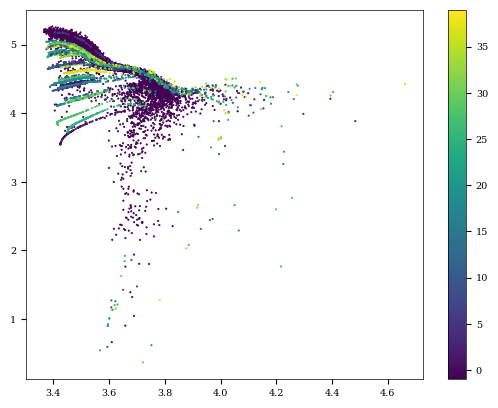

In [10]:
plt.scatter(logT, logg, s=1, c=df.labels, cmap='viridis')
plt.colorbar()

# Create a PhotData object and set the parameters

In [18]:
data = PhotData()
data.logAge = logAge
data.Z = Z_metal
data.logT = logT
data.logg = logg
data.logL = logL
data.mass = mass
data.Av = Av_orig
data.skycoords = skycoords

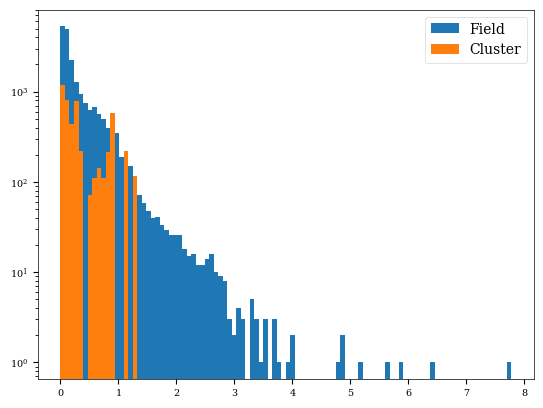

In [12]:
# _, bins, _ = plt.hist(Av_orig[df.labels==-1], bins=100, log=True, label='Field')
# plt.hist(Av_orig[df.labels!=-1], bins=bins, log=True, label='Cluster')
# plt.legend()
# plt.show()

In [16]:
phpipe = PhotometryPipeline(steps=[
    # ('disk_prop', CondDiskProperties()),
    # ('yso_model', YSO(base_dir=base_path_yso, yso_models='all')),
    ('spectrum', SpectrumGenerator(stellib=pystellibs.BTSettl())),
    # ('spectrum', SpectrumGenerator(stellib=pystellibs.BaSeL())),
    # ('dustmap', DustMap(map_base_path=dustmap_base_path, dustmap_name='edenhofer')),
    # ('dustmap', DustMap(map_base_path=dustmap_base_path, dustmap_name='bayestar', mode='best')),
    # ('filter', Photometry(filter_names=["GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac']))
])

In [19]:
data = phpipe.run(data)
# data.aperture_arcsec = 3*np.ones(data.N) * u.arcsec

Generating spectra for 23278 sources (out of 25000)


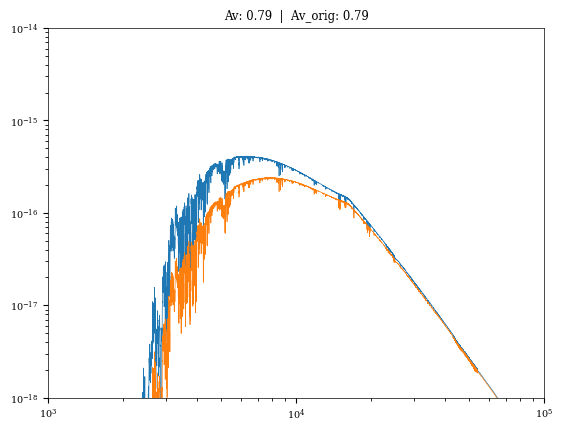

In [20]:
idx = 5
plt.loglog(data.wavelength.value, data.flam.value[idx], lw=0.5)
plt.loglog(data.wavelength.value, data.flam_dusty.value[idx], lw=0.5)
plt.ylim(1e-18, 1e-14)
plt.xlim(1000, 100000)
plt.title(f'Av: {data.Av[idx]:.2f}  |  Av_orig: {Av_orig[idx]:.2f}')

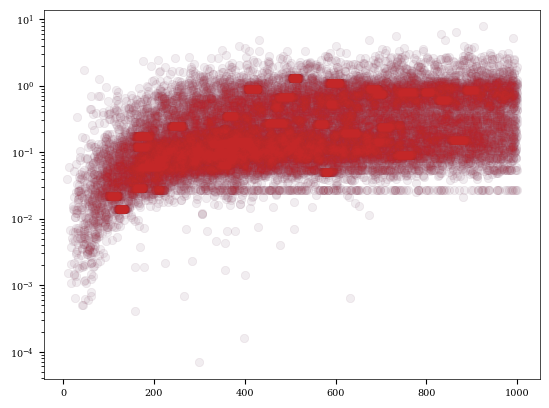

In [21]:
# plt.scatter(1000/df_final.parallax.values, data.Av - df_final.Av.values, alpha=0.01);
plt.scatter(d_orig, data.Av, alpha=0.05)
plt.scatter(d_orig, Av_orig, alpha=0.05, c='tab:red')
plt.yscale('log')

In [22]:
# d_Av = data.Av - Av_orig
# # plt.scatter(data.skycoords.dec, data.Av, alpha=0.01)
#
# # plt.scatter(data.skycoords.dec[df.labels==-1], d_Av[df.labels==-1], alpha=0.01)
# # plt.scatter(data.skycoords.dec[df.labels!=-1], d_Av[df.labels!=-1], alpha=0.01)
#
# _, bins, _ = plt.hist(d_Av[df.labels==-1], bins=100, log=True, label='Field')
# plt.hist(d_Av[df.labels!=-1], bins=bins, alpha=0.7)

In [24]:
# # x_plt = skycoords.dec.value
# x_plt = df.Z_pc.values
#
# plt_clsts = True
# for li in np.unique(df.labels):
#     if plt_clsts and li>-1:
#         plt.hist(x_plt[df.labels==li], bins=np.linspace(-90, 90, 100), log=False)
#     elif li==-1:
#         plt.hist(x_plt[df.labels==li], bins=np.linspace(-90, 90, 100), log=False)
# plt.show()

In [25]:
# plt.hist(data.Av, bins=100, log=True);

In [26]:
# plt.hist(df['Av'].values, bins=100, log=True);

In [27]:
filter_step = PhotometryPipeline(steps=[
    ('filter', Photometry(filter_names=[
        "GAIA/GAIA3.Gbp", "GAIA/GAIA3.G", "GAIA/GAIA3.Grp", '2mass', 'irac', 'wise', 'PS1'
    ]))
])

In [28]:
data = filter_step.run(data)

In [29]:
data.mag_band.keys()

dict_keys(['GAIA_GAIA3.Gbp', 'GAIA_GAIA3.G', 'GAIA_GAIA3.Grp', '2MASS_H', '2MASS_J', '2MASS_Ks', 'SPITZER_IRAC_36', 'SPITZER_IRAC_45', 'SPITZER_IRAC_58', 'SPITZER_IRAC_80', 'WISE_RSR_W1', 'WISE_RSR_W2', 'WISE_RSR_W3', 'WISE_RSR_W4', 'PS1_g', 'PS1_i', 'PS1_r', 'PS1_w', 'PS1_y', 'PS1_z'])

In [30]:
all_band_cl = {}
for i, (b, flx) in enumerate(data.flam_band.items()):
    cl = data.cl_band[b]
    all_band_cl[b] = np.round(cl.value, 2)

all_band_cl

{'GAIA_GAIA3.Gbp': 5182.58,
 'GAIA_GAIA3.G': 6390.22,
 'GAIA_GAIA3.Grp': 7825.08,
 '2MASS_H': 16513.66,
 '2MASS_J': 12408.38,
 '2MASS_Ks': 21655.84,
 'SPITZER_IRAC_36': 35634.29,
 'SPITZER_IRAC_45': 45110.14,
 'SPITZER_IRAC_58': 57593.37,
 'SPITZER_IRAC_80': 79594.93,
 'WISE_RSR_W1': 33791.91,
 'WISE_RSR_W2': 46292.96,
 'WISE_RSR_W3': 123337.58,
 'WISE_RSR_W4': 222532.36,
 'PS1_g': 4866.46,
 'PS1_i': 7544.57,
 'PS1_r': 6214.62,
 'PS1_w': 6389.35,
 'PS1_y': 9633.26,
 'PS1_z': 8679.48}

In [31]:
df['gaia_bp_phot'] = data.mag_band['GAIA_GAIA3.Gbp'].value
df['gaia_rp_phot'] = data.mag_band['GAIA_GAIA3.Grp'].value
df['gaia_g_phot'] = data.mag_band['GAIA_GAIA3.G'].value
df['ps1_g'] = data.mag_band['PS1_g'].value
df['ps1_i'] = data.mag_band['PS1_i'].value
df['ps1_r'] = data.mag_band['PS1_r'].value
df['ps1_w'] = data.mag_band['PS1_w'].value
df['ps1_y'] = data.mag_band['PS1_y'].value
df['ps1_z'] = data.mag_band['PS1_z'].value
df['2mass_h'] = data.mag_band['2MASS_H'].value
df['2mass_j'] = data.mag_band['2MASS_J'].value
df['2mass_k'] = data.mag_band['2MASS_Ks'].value
df['irac_1'] = data.mag_band['SPITZER_IRAC_36'].value
df['irac_2'] = data.mag_band['SPITZER_IRAC_45'].value
df['irac_3'] = data.mag_band['SPITZER_IRAC_58'].value
df['irac_4'] = data.mag_band['SPITZER_IRAC_80'].value
df['wise_1'] = data.mag_band['WISE_RSR_W1'].value
df['wise_2'] = data.mag_band['WISE_RSR_W2'].value
df['wise_3'] = data.mag_band['WISE_RSR_W3'].value
df['wise_4'] = data.mag_band['WISE_RSR_W4'].value
# df['Av_true'] = data.Av
df['Av_obs'] = Av_orig

(17.0, -4.0)

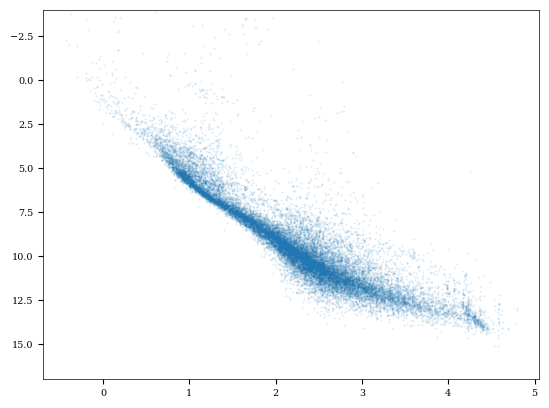

In [32]:
M_G = df['gaia_g_phot'] - 5 * np.log10(1000 / df['parallax_obs']) + 5
BP_RP = df['gaia_bp_phot'] - df['gaia_rp_phot']

plt.scatter(BP_RP, M_G, s=1, alpha=0.1)
plt.ylim(17, -4)

 # LAMOST simulated

In [33]:
def lamost_grid(n_pix=3825, loglam_start=3.5673, dloglam=0.0001):
    """
    Generate the LAMOST log-lambda wavelength grid.
    loglam_start ~ log10(3690)
    dloglam ~ 0.0001
    """
    loglam = loglam_start + np.arange(n_pix) * dloglam
    lam = 10 ** loglam
    return lam * u.AA

def boss_wavelength_grid(n_pix=4000, coeff0=3.5816, coeff1=1e-4):
    loglam = coeff0 + np.arange(n_pix) * coeff1
    lam = 10 ** loglam
    return lam

def apogee_wavelength_grid(n_pix=7214, start=15140.0, delta_lambda=0.149):
    return start + np.arange(n_pix) * delta_lambda

def xp_wavelength_grid(start_aa=3920, end_aa=9920, step_aa=100):
    return np.arange(start_aa, end_aa + step_aa, step_aa)

wavelength_grids = {
    'lamost': lamost_grid,
    'boss': boss_wavelength_grid,
    'apogee': apogee_wavelength_grid,
    'xp': xp_wavelength_grid,
}

In [34]:
wave_grid_old = data.wavelength
spectra = data.flam_dusty
logAges = data.logAge

In [35]:
set_nan = False
w_all = []
for w_name, w_grid_func in wavelength_grids.items():
    w_grid = w_grid_func()
    spectra_new = batch_interp_numba(wave_grid_old, w_grid, spectra)
    # randomly set 50% of rows to NaN
    if set_nan:
        M = spectra_new.shape[0]
        rows_to_nan = np.random.choice(M, size=M // 2, replace=False)
        # Set selected rows to NaN
        spectra_new[rows_to_nan, :] = np.nan

    column_names = [f'{w_name}_{i}' for i in range(spectra_new.shape[1])]
    df_wave = pd.DataFrame(spectra_new, columns=column_names)
    w_all.append(df_wave)
    # print(df_wave.shape)

In [263]:
# plt.hist(df.Av_true - df.Av_obs, bins=100, log=True, label='Av_true - Av_obs');

In [264]:
# np.sum(np.abs(df.Av_true - df.Av_obs) > 1.) / df.shape[0] * 100

In [265]:
dfs = [df] + w_all
df_final = pd.concat([d.reset_index(drop=True) for d in dfs], axis=1)

In [266]:
# skycoords_final = SkyCoord(
#     ra=df_final['ra'].values * u.deg,
#     dec=df_final['dec'].values * u.deg,
#     distance=1000 / df_final['parallax'].values * u.pc,
#     frame='icrs'
# )
# sc_gal = skycoords_final.transform_to(Galactic())
# df_final['l'] = sc_gal.l.value
# df_final['b'] = sc_gal.b.value

In [267]:
# plt.hist(df_final.Av_true - df_final.Av_obs, bins=100, log=True);

In [268]:
fname_save = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_field_1kpc_fundamentals_Bayestar2019_SED_BaSeL_July2025_corrected_inclPS1.parquet'
# fname_save = '/Users/ratzenboe/Library/CloudStorage/Dropbox/work/data/mock_edr3/cluster_field_1kpc_fundamentals_Edenhofer_SED_BTSettl_July2025_diffClusters_corrected_inclPS1.parquet'
df_final.to_parquet(fname_save)

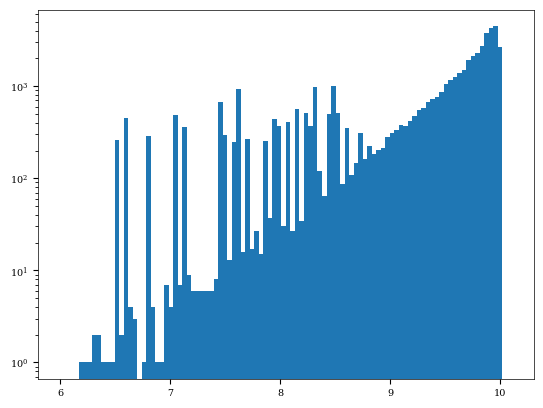

In [269]:
plt.hist(logAges, bins=100, range=(6., 10.1), log=True);

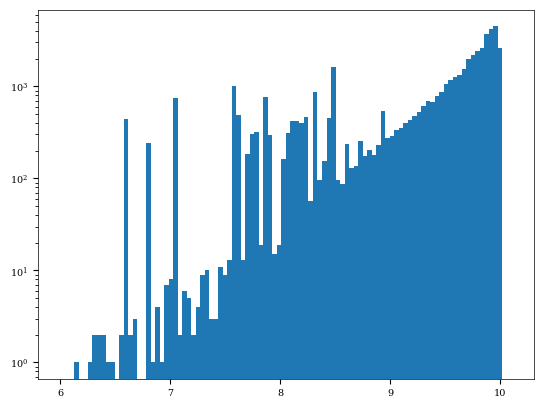

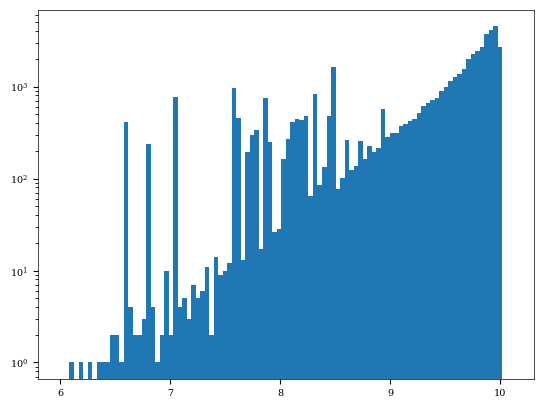

In [57]:
# plt.hist(logAges, bins=100, range=(6., 10.1), log=True);

In [28]:
show_n = 10
idx = np.where(logAges < 7)[0][:show_n].tolist() #+ np.where(logAges > 7)[0][:show_n].tolist()
for i in idx:
    if logAges[i] >= 7:
        ls = '-'
    else:
        ls = '--'
    plt.loglog(l_grid, spectra_new[i], label=f'{logAges[i]:.1f}', ls=ls)

# put legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# Lithium line at 6708 Angstroms
plt.axvline(6708, color='k', ls='--', lw=0.5)
# H alpha line at 6563 Angstroms
plt.axvline(6563, color='k', ls='--', lw=0.5)

NameError: name 'l_grid' is not defined